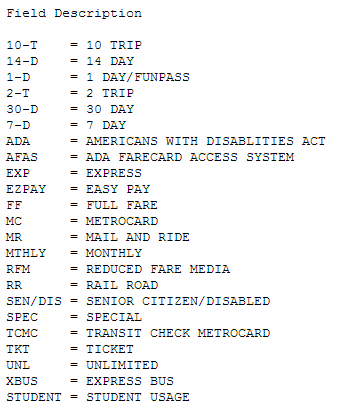

In [5]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
import urllib

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%matplotlib inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")


# Time-Series Analysis README.md group collaborators
# fekade
# andrea
#yg833
#qg412


In [6]:
urllib.request.urlretrieve('https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy','MTA_Fare.npy')

('MTA_Fare.npy', <http.client.HTTPMessage at 0x7fb5f68bce80>)

In [7]:
!mv MTA_Fare.npy "/nfshome/jl9489/PUI2018/HW11_jl9489"

mv: 'MTA_Fare.npy' and '/nfshome/jl9489/PUI2018/HW11_jl9489/MTA_Fare.npy' are the same file


In [8]:
mta_fare = np.load('MTA_Fare.npy')

In [9]:
mta_fare.size

2677200

## read in data as instructed above

In [11]:
print ("MTA array shape:", mta_fare.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta_fare,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [12]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [13]:
mta_weeks = pd.date_range(start='5/19/2010', periods=194, freq='W')

In [14]:
mta_weeks

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [15]:
mta_fare = mta_fare.astype(float)

In [16]:
mta_fare[mta_fare == -1.00000000e+00] = 'nan'

In [17]:
mta_fare

array([[[  5.69610000e+04,   6.47030000e+04,   6.80020000e+04, ...,
           3.65270000e+04,   3.39290000e+04,   3.68240000e+04],
        [  1.73200000e+03,   2.08300000e+03,   2.10700000e+03, ...,
           1.26400000e+03,   1.17200000e+03,   1.23800000e+03],
        [  2.03000000e+02,   2.76000000e+02,   2.45000000e+02, ...,
           1.86000000e+02,   1.67000000e+02,   1.67000000e+02],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [             nan,              nan,              nan, ...,
           1.12100000e+03,   1.37700000e+03,   7.12000000e+02]],

       [[  1.62100000e+04,   2.01790000e+04,   2.17690000e+04, ...,
                      nan,              nan,              nan],
        [  5.03000000e+02,   6.47000000e+02,   6.65000000e+0

In [18]:
mta_fare = np.nan_to_num(mta_fare)

In [63]:
mta_fare.dtype

dtype('float64')

In [20]:
mta_fare.shape

(600, 23, 194)

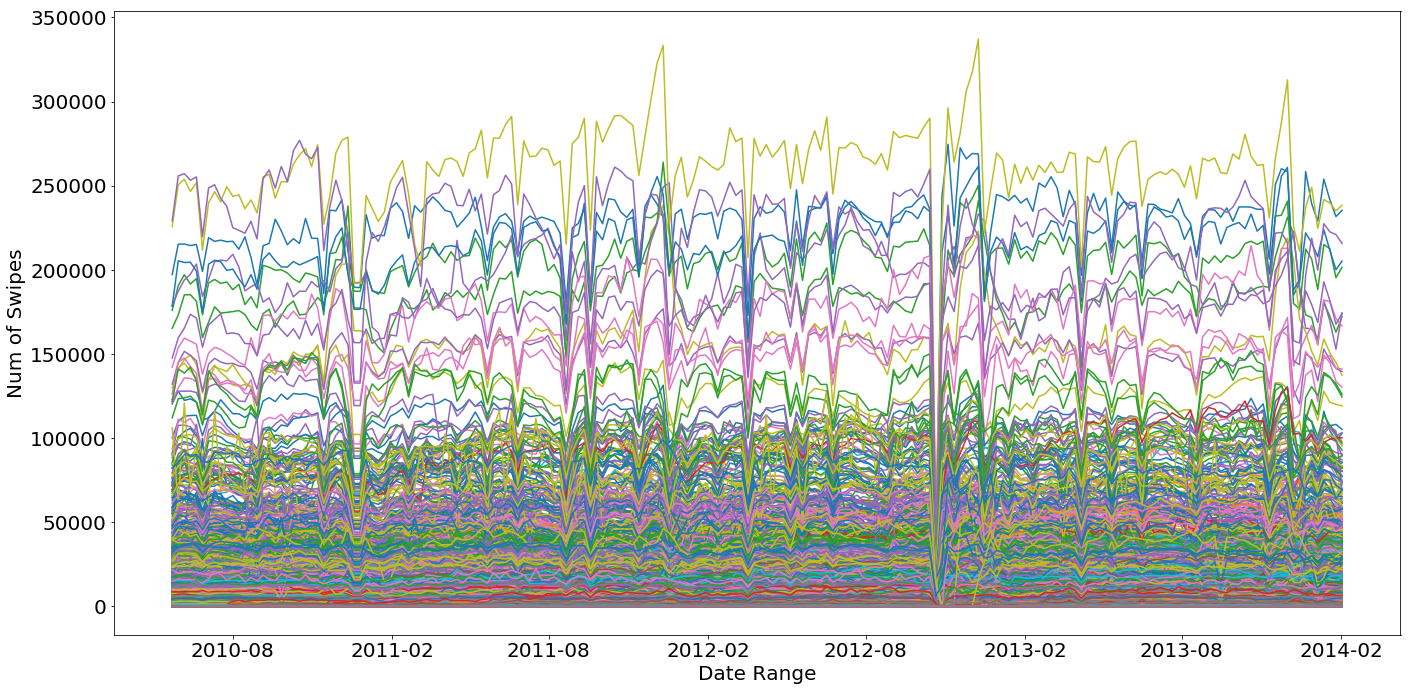

In [21]:
fig, ax = plt.subplots(figsize=(20,10))


for i in list(range(0,599)):
    for j in list(range(0,22)):
        ax.plot(mta_weeks,mta_fare[i][j])
        

plt.xlabel('Date Range')
plt.ylabel('Num of Swipes')
plt.tight_layout()

Fig 1: The above plot shows the number of swipes on MTA buses in the given dataset.  It creates a very messy plot, which makes it difficult to find any clear patterns.

In [22]:
mta_fare_log = np.log10(mta_fare)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


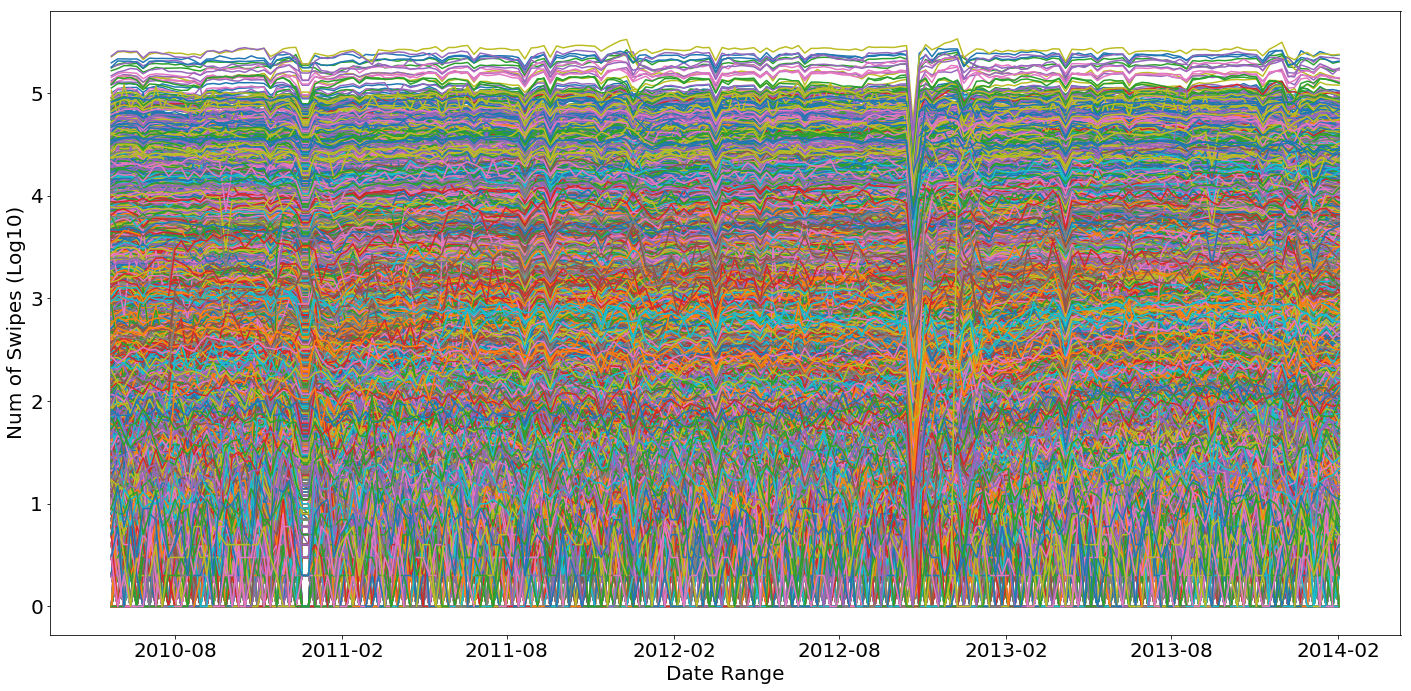

In [23]:
fig, ax = plt.subplots(figsize=(20,10))


for i in list(range(0,599)):
    for j in list(range(0,22)):
        ax.plot(mta_weeks,mta_fare_log[i][j])
        

plt.xlabel('Date Range')
plt.ylabel('Num of Swipes (Log10)')
plt.tight_layout()

Fig 2: The above plot shows the total number of MTA card swipes over the different buses, plotted over a logarithmic scale.  While it is difficult to discern patterns, there is a clear dip in the number of swipes.  This most likely corresponds to the direct aftermath of Hurricane Sandy (10-22-2012 to 11-2-2012), which affected public transportation throughout NYC.

## 1: event detection

In [24]:
def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = np.nancumsum(data)
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': (data[:changePoint+1]).mean(), 
            'meanAfter': (data[(changePoint+1):]).mean()}

In [26]:
pochange = changeFinder(mta_fare[0][0])
pochange['pointOfChange']

127

In [46]:
# Create an array of total swipe counts by week

mta_fare2 = np.nansum(mta_fare, axis=0)
mta_fare3 = np.nansum(mta_fare2, axis=0)

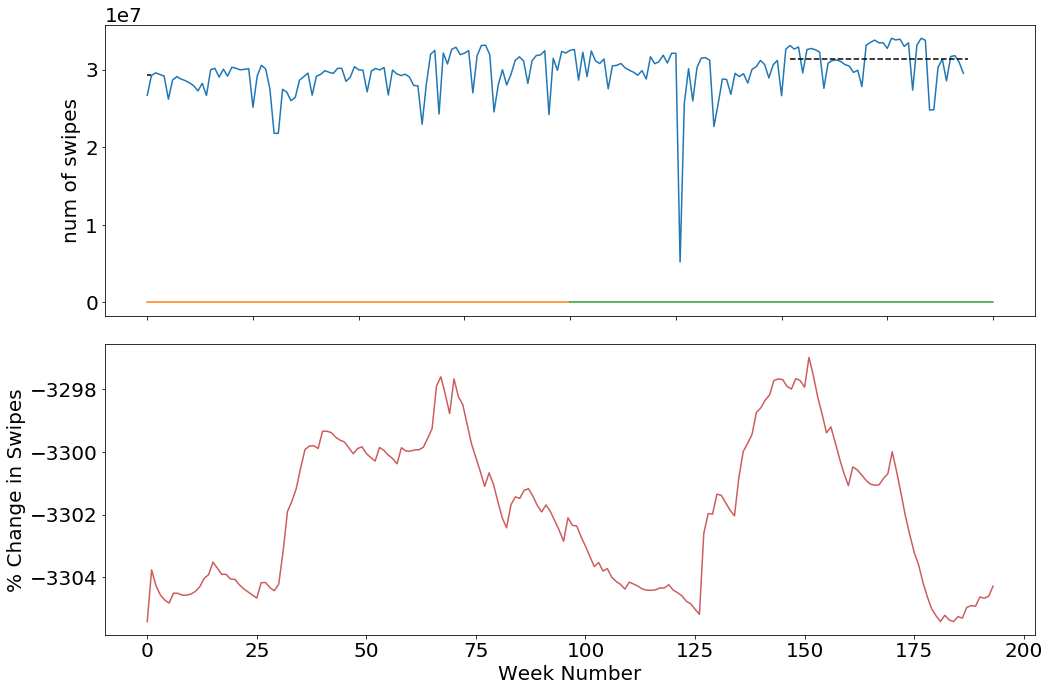

In [52]:
fig = pl.figure(figsize=(15,10))
ax1 = pl.subplot(211)
ax1.plot(range(len(mta_fare3)), mta_fare3)
ax1.plot([0,100], [0,0], '-')
ax1.plot([100,200],[3,3], '-')
ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("num of swipes")

ax2 = pl.subplot(212)
ax2.plot(range(len(mta_fare3)), 
        pochange['pChange'], color="IndianRed")
ax1.plot(0,[pochange['pointOfChange']], 
         [pochange['meanBefore'], pochange['meanBefore']], 'k--')
ax1.plot([pochange['pointOfChange'],len(mta_fare3)], 
         [pochange['meanAfter'], pochange['meanAfter']], 'k--')
ax2.set_ylabel("% Change in Swipes")
ax2.set_xlabel("Week Number")

pl.tight_layout()

In [53]:
# Determine the statistics for swipe count

print ("mean swipes by day {:.2f}".format(mta_fare3.mean()))
print ("stdev swipes by day {:.2f}".format(mta_fare3.std()))
thresholds = [mta_fare3.mean() + 3 * mta_fare3.std(), 
              mta_fare3.mean() - 3 * mta_fare3.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean swipes by day 29781349.87
stdev swipes by day 2983960.42
3-sigma thresholds 38733231.14 20829468.61


In [61]:
# Find value below the 3-sigma threshold

mta_fare3 < thresholds[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [64]:
# Convert to dataframe for easier plot

mtatest = pd.DataFrame(data=mta_fare3)

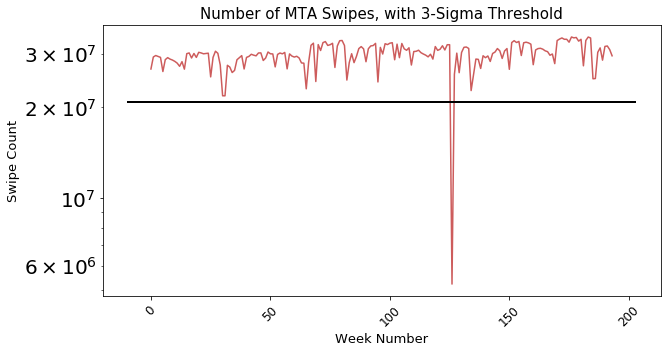

In [79]:
# Plot the threshold to find outliers

ax = mtatest.plot(logy=True, figsize=(10,5), style="-", ms=20, color="IndianRed")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color="Black", lw=2)
ax.legend().remove()
pl.xticks(rotation=45, fontsize=12)
pl.xlabel('Week Number',fontsize=13)
pl.ylabel('Swipe Count',fontsize=13)
pl.title('Number of MTA Swipes, with 3-Sigma Threshold',fontsize=15)